**DAY 1**

**Part 1: Acquiring the IR-GFP Data**

Depending on the source, data will be stored in different formats.  
In this case, the data is from DeltaVision's software and is stored in .dt1 files.
Each file consists of a header with several flags marked with '@**@flag_name'.
The final flag is '@**@data' which is followed by a 307,200 pixel values.

These represent 3 flattened images: the Light Image (IR-Transmission), Shear0, and Shear45 images.

This first part of this script: 

*   Reads .dt1 files
*   Parses the data for the 3 images data specifically.
*   Reshapes the flattened arrays into images.
*   Displays and / or saves the images.


First, get everything you need from github:

In [1]:
!git clone https://github.com/johnsonht/bowtie_tutorial

Cloning into 'bowtie_tutorial'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 303 (delta 6), reused 0 (delta 0), pack-reused 288
Receiving objects: 100% (303/303), 198.06 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (249/249), done.


Now, read the data files:

In [2]:
import array

import numpy as np
import matplotlib.pyplot as plt
import glob


def get_images(filename, xdim = 640, ydim = 480):
    """
    Parses .dt1 file to extract 3 images.
    Returns Light Image, Shear0 Image, Shear45 Image in the form of numpy arrays.
    """
    filestring = open(filename,"rb").read()
    
    # Image data begins 34 bytes after the '@**@Data' flag
    idx = filestring.rfind(b'@**@Data')
    splitstring = filestring[idx+34:]
    f = array.array('f')
    #f.fromstring(splitstring)
    f.frombytes(splitstring)
    f = np.asarray(f)

    # Separate into 3 image types IR Transmission (Light), Shear0, and Shear 45
    imgLight = f[:xdim*ydim].reshape(ydim, xdim)

    # Shear 45 Image (must be normalized by light image)
    img45 = f[xdim*ydim: 2*xdim*ydim].reshape(ydim, xdim)
    with np.errstate(divide='ignore', invalid='ignore'):
        img45 = np.true_divide(img45,imgLight)
        img45[img45 == np.inf] = 1
        img45 = np.nan_to_num(img45)
        
    # Shear 0 Image (must be normalized by light image)
    img0 = f[2*xdim*ydim:3*xdim*ydim].reshape(ydim,xdim)        
    with np.errstate(divide='ignore', invalid='ignore'):
        img0 = np.true_divide(img0,imgLight)
        img0[img0 == np.inf] = 1
        img0 = np.nan_to_num(img0)
    
    return imgLight, img0, img45

...having obtained the data, we now plot the images:

In [3]:
def show_images(imgL, img0, img45):
    """Plots Light, Shear0 and Shear45 images in grayscale."""
    plt.gray() 
    plt.figure('Light')
    plt.imshow(imgL)
    plt.title("IR Transmission")
    plt.figure('Shear 0')
    plt.imshow(img0)
    plt.title("Shear 0")
    plt.figure('Shear 45')
    plt.imshow(img45)
    plt.title("Shear 45")

Now we save the image files:

In [4]:
def save_images(file_names, save_file = "/content/bowtie_tutorial/images/5x_images/"):
    """Saves a copy of each image."""
    for i, file in enumerate(file_names):
        print('Saving',i,'/',len(file_names))
        imgL, img0, img45 = get_images(file)
        plt.imsave(f'{save_file}{i}_Light.png', imgL)
        plt.imsave(f'{save_file}{i}_Shear0.png', img0)
        plt.imsave(f'{save_file}{i}_Shear45.png', img45)

...and display one set of Light, Shear 0, and Shear 45 images.

Saving 0 / 25
Saving 1 / 25
Saving 2 / 25
Saving 3 / 25
Saving 4 / 25
Saving 5 / 25
Saving 6 / 25
Saving 7 / 25
Saving 8 / 25
Saving 9 / 25
Saving 10 / 25
Saving 11 / 25
Saving 12 / 25
Saving 13 / 25
Saving 14 / 25
Saving 15 / 25
Saving 16 / 25
Saving 17 / 25
Saving 18 / 25
Saving 19 / 25
Saving 20 / 25
Saving 21 / 25
Saving 22 / 25
Saving 23 / 25
Saving 24 / 25


<Figure size 432x288 with 0 Axes>

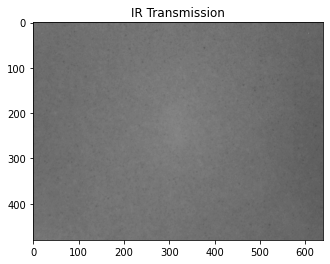

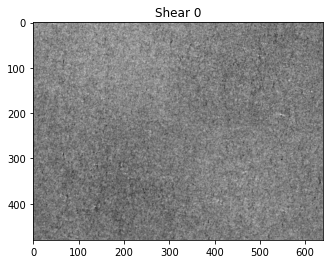

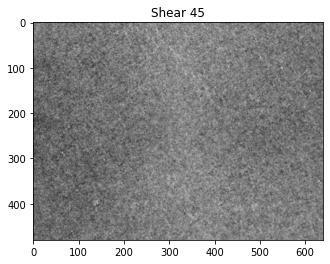

In [5]:
if __name__ == "__main__":
    plt.close('all')
    FILES = glob.glob('/content/bowtie_tutorial/Wafer_Data_Files/*.dt1')
    IMAGE_NUMBER = 1 # choose an image to view from 0 to 24
    imgL, img0, img45 = get_images(FILES[IMAGE_NUMBER])
    show_images(imgL, img0, img45)
    save_images(FILES)

**Part 2: Cleaning the GFP Data**

Most datasets have some form of undesired artifacts.
One such artifact in this dataset is hypersensitive pixels.
A hypersensitive pixel is a pixel that regularly has a value
much higher than the other pixels in the image.  They arise
due to thermal effects in the detector.  
Given their nature, they can be easily identified by recording the
most intense pixel in a sample of images. 

Given the number of pixels in the image, the number of images, 
and assuming all pixels have a roughly equal probability of being
the most intense pixel in the image, we can predict the probability
of any pixel occuring as the most intense pixel N times and replace
those pixels that occur as the most intense pixel too frequently.
Replacement can be done by resetting the value of the pixel value to the mean value of the neighboring pixels.
This process can be done recursively since replacing one hot pixel may reveal another.
Take a look at the images in ./images/5x_images.  Can you spot a hypersensitive pixel?

First we look for hot pixels and mark their coordinates.  Then we replace them, and plot the "before" and "after" images.

Inspecting 0 / 25
Inspecting 1 / 25
Inspecting 2 / 25
Inspecting 3 / 25
Inspecting 4 / 25
Inspecting 5 / 25
Inspecting 6 / 25
Inspecting 7 / 25
Inspecting 8 / 25
Inspecting 9 / 25
Inspecting 10 / 25
Inspecting 11 / 25
Inspecting 12 / 25
Inspecting 13 / 25
Inspecting 14 / 25
Inspecting 15 / 25
Inspecting 16 / 25
Inspecting 17 / 25
Inspecting 18 / 25
Inspecting 19 / 25
Inspecting 20 / 25
Inspecting 21 / 25
Inspecting 22 / 25
Inspecting 23 / 25
Inspecting 24 / 25

Light
Counter({15968: 25})

Shear0
Counter({16875: 1, 97894: 1, 4599: 1, 134997: 1, 27639: 1, 93659: 1, 91569: 1, 139214: 1, 62797: 1, 174743: 1, 140098: 1, 224471: 1, 65451: 1, 7903: 1, 28279: 1, 72209: 1, 4707: 1, 76317: 1, 16375: 1, 37706: 1, 126521: 1, 25859: 1, 228294: 1, 54512: 1, 40468: 1})

Shear45
Counter({15546: 2, 1244: 1, 260325: 1, 70513: 1, 11081: 1, 190545: 1, 197545: 1, 287713: 1, 1680: 1, 14826: 1, 19393: 1, 80976: 1, 34822: 1, 302497: 1, 28279: 1, 132635: 1, 175819: 1, 244617: 1, 262533: 1, 289066: 1, 197300: 1

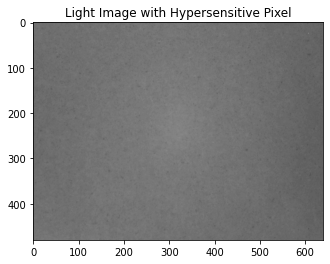

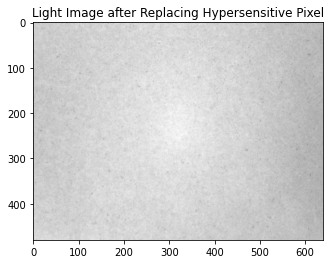

In [6]:
import collections


def find_hot_pixels(file_names):
    """Keeps track of how many times each pixel occurred as the most intense pixel in each image."""
    counter = {'Light': collections.Counter(),
             'Shear0': collections.Counter(),
             'Shear45': collections.Counter()
             }
    for i, file in enumerate(file_names):
        print('Inspecting',i,'/',len(file_names))
        imgL, img0, img45 = get_images(file)
        counter['Light'][np.argmax(imgL)] += 1
        counter['Shear0'][np.argmax(img0)] += 1
        counter['Shear45'][np.argmax(img45)] += 1
    print()
    return counter

def pixel_to_xy(pixel, xdim=640):
    """
    Takes pixel index and returns tuple of (x, y) coordinates. 
    y+ axis is down, x+ axis is right, and (0, 0) is the top left corner.
    """
    return (pixel%xdim, pixel//xdim)

def replace_hot_pixels(image, hot_pixels, xdim=640, ydim=480):
    """Replaces hot pixels with the mean of their 8-directionally adjacent neighbors"""
    for pixel in hot_pixels:
        x, y = pixel_to_xy(pixel)
        neighbors = []
        for i in range(max(0, y-1), min(y+2, ydim)):
            for j in range(max(0, x-1), min(x+2, xdim)):
                if i != j:
                    neighbors.append(image[i][j])
        image[y][x] = sum(neighbors) / len(neighbors) if neighbors else 0
    return image
        
if __name__ == "__main__":
    plt.close('all')
    FILES = glob.glob('/content/bowtie_tutorial/Wafer_Data_Files/*.dt1')
    
    # Count how many times each pixel occurs as the most intense pixel in an image
    counter = find_hot_pixels(FILES)
    for key in counter:
        print(key)
        print(counter[key])
        print()
        
    print("Suspect:", pixel_to_xy(list(counter['Light'].keys()).pop()))
    print("Suspect:", pixel_to_xy(15546))
    
    # Inspect image before replacing pixel
    imgL, img0, img45 = get_images(FILES[0])
    plt.figure(1)
    plt.imshow(imgL)
    plt.title("Light Image with Hypersensitive Pixel")
    
    # Replace the hot pixels
    hot_pixels = [15968, 15546]
    imgL = replace_hot_pixels(imgL, hot_pixels)
    
    # Inspect image after replacing hot pixel (notice the contrast change)
    plt.figure(2)
    plt.imshow(imgL)    
    plt.title("Light Image after Replacing Hypersensitive Pixel")

Imperfections in the light source, optic path, and detector can result in optical aberrations.
When an aberration is consistently present in the same location, across all images, while the other 
features on the image change, then a subtraction image can be used to remove the optical aberration.

Given the limited data in this tutorial, we will use all of the provided images to create
a subtraction image.  
We will create one subtraction image for the shear 0 images, and one for the shear 45 images.
This is done by simply averaging all of the images, or:

sub0[i][j] = sum(img0[i][j] for img0 in all_shear0_images) / number_of_shear0_images

Then we can subtract the subtraction image from the raw image.

Subtraction images are not perfect.  They can be used to remove consistent optical aberrations
from an image, but they also affect the remaining pixel values.  Consider what additional information
in the image may be lost or altered when applying a subtraction image.  

0 / 25
1 / 25
2 / 25
3 / 25
4 / 25
5 / 25
6 / 25
7 / 25
8 / 25
9 / 25
10 / 25
11 / 25
12 / 25
13 / 25
14 / 25
15 / 25
16 / 25
17 / 25
18 / 25
19 / 25
20 / 25
21 / 25
22 / 25
23 / 25
24 / 25


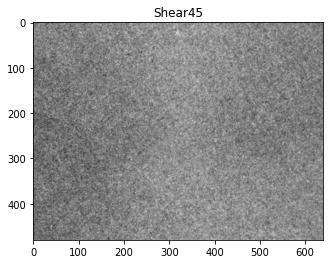

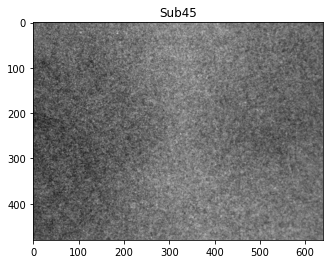

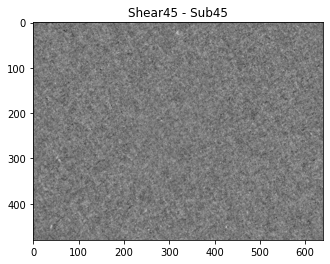

In [8]:
def create_subtraction_images(file_names, xdim=640, ydim=480):
    """Creates 2 subtraction images by averaging all shear0 and shear45 images."""
    sub0 = np.zeros((ydim, xdim))
    sub45 = np.zeros((ydim, xdim))
    for i, file_name in enumerate(file_names):
        print(i,'/',len(file_names))
        imgL, img0, img45 = get_images(file_name)
        sub0 += img0
        sub45 += img45
    return sub0 / len(file_names), sub45 / len(file_names)

if __name__ == "__main__":
    plt.close('all')
    FILES = glob.glob('/content/bowtie_tutorial/Wafer_Data_Files/*.dt1') # get a list of the path to each .dt1 file
    
    # Pick an image between 0 and 24
    IMAGE_NUMBER = 20
    
    # Show raw Images
    imgL, img0, img45 = get_images(FILES[IMAGE_NUMBER])
    plt.figure(0)
    plt.imshow(img45)
    plt.title('Shear45')
    
    # Create subtraction images
    sub0, sub45 = create_subtraction_images(FILES)
    
    # Save subtraction images as .npy so they can be easily loaded as a numpy array later
    np.save('/content/bowtie_tutorial/images/subtraction_images/sub0.npy', sub0)
    np.save('/content/bowtie_tutorial/images/subtraction_images/sub45.npy', sub45)
    
    # Show subtraction images
    plt.figure(1)
    plt.imshow(sub45)
    plt.title('Sub45')
    
    # Apply subtraction images
    imgL, img0, img45 = get_images(FILES[IMAGE_NUMBER])
    img0 -= sub0
    img45 -= sub45
    plt.figure(2)
    plt.imshow(img45)
    plt.title('Shear45 - Sub45')

**Assignment**: find one of the shear zero or shear 45 images that, when cleaned by removing hot pixels and corrected with a subtraction image, shows bowtie images more clearly.  Turn in the "before" and "after" .png images.

**DAY 2**

**Part 1: Annotate Some Images**

Now that we know how to remove optical aberations and hypersensitive pixels,
it's time to get the training data.  
This is often a very time intensive step, in particular for supervised learning
models that require labeled data.
In this script we will identify 25 regions per image that can be used for training data.
The image will be split into 25 evenly sized regions and in each region a box is placed
around the most intense pixel.  The intensity of pixel (i, j) is $img0[i][j]^2 + img45[i][j]^2$.
The most intense pixel is chosen in each region, because bowties tend to contain the highest
intensity pixel in a subregion.  
The end result will be 25 Shear0 and Shear45 images that each have 25 boxed regions.
The boxed regions will be characterized by a human as either containing
a bowtie or not containing a bowtie. 

In [31]:
from matplotlib.offsetbox import TextArea, AnnotationBbox

def subdivide(image, N, xdim=640, ydim=480):
    """
    Divides image into N*N subimages.
    Returns a list of these subimages.
    """
    dx, dy = xdim // N, ydim // N
    subimages = []
    for i in range(0, ydim, dy):
        for j in range(0, xdim, dx):
            subimages.append(image[i:i+dy, j:j+dx])
    return subimages

def local_to_global_index(i, j, dx, dy, N):
    """Converts the index of peak value in a subdivided image to the index in the original image."""
    return N*(j//N)*dx*dy + N*dx*(i//dx) + dx*(j%N) + i%dx

def add_boxes(image, points, size=10, xdim=640, ydim=480):
    """
    Places a white box of edge length 2*size around each point in points.
    Returns the image with boxes added.
    
    image: numpy array of dimensions (xdim, ydim)
    points: a list of points to be boxed
    """
    max_val = np.max(image)
    for point in points:
        j, i = pixel_to_xy(point)
        for di in range(max(0, i-size), min(ydim, i+size+1)):
            if j + size < xdim:
                image[di][j+size] = max_val
            if j - size >= 0:
                image[di][j-size] = max_val
        for dj in range(max(0, j-size), min(xdim, j+size+1)):
            if i + size < ydim:
                image[i+size][dj] = max_val
            if i - size >= 0:
                image[i-size][dj] = max_val
    return image

Now we annotate the image by placing a box around potential bowties.  First we apply the image processing steps: subtraction image and hot pixel removal
  
Next we divide the image into NxN subimages, and for each subimage, we place a box around the most intense pixel.
  
The intensity of pixel (i, j) is $img0[i][j]^2 + img45[i][j]^2$.  Finally, we save the annotated image.
    
    Note:
    file_name: path to .dt1 image file
    sub0, sub45: subtraction images (numpy array)
    img_number: number of the image to be saved
    save_dir: location where the annotated images should be saved
    hot_pixels: the pixel id of known hypersensitive pixels
    xdim, ydim: dimensions of the image in pixels (typically 640 by 480)

<ipython-input-32-9b589a7badc3>:33: MatplotlibDeprecationWarning: 
The 'minimumdescent' parameter of __init__() was deprecated in Matplotlib 3.4 and will be removed two minor releases later. If any parameter follows 'minimumdescent', they should be passed as keyword, not positionally.
  offsetbox = TextArea(str(j), minimumdescent=False)


<Figure size 1800x1200 with 0 Axes>

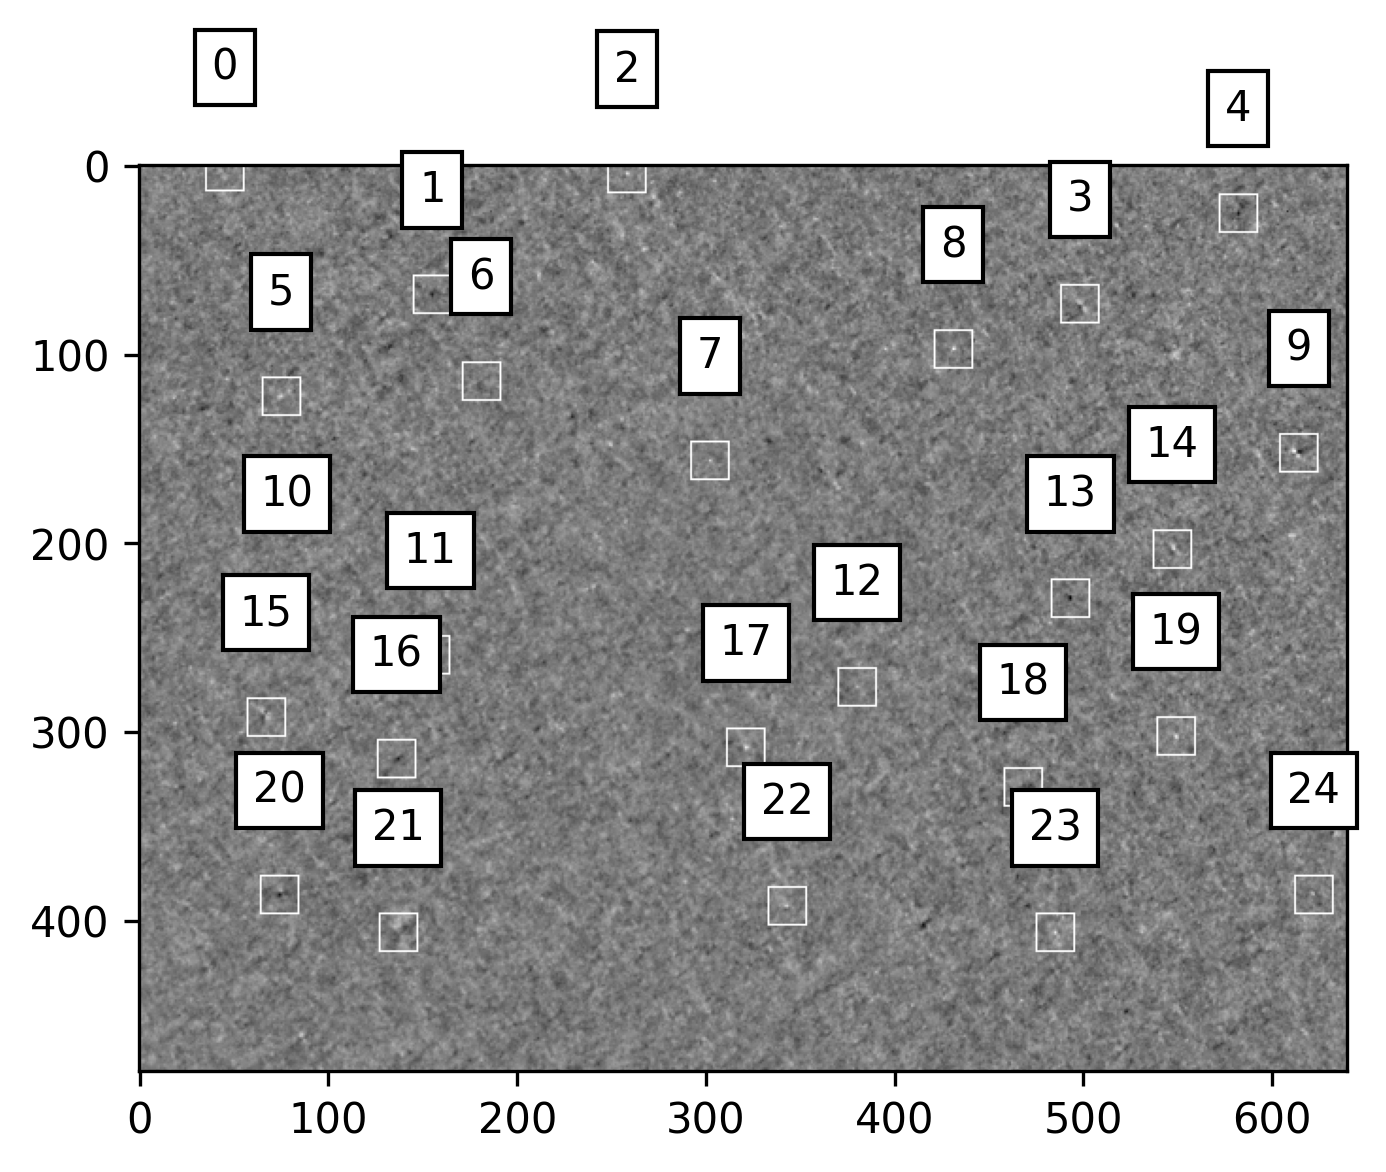

In [32]:
def annotate_image(file_name, sub0, sub45, img_number, N=5, save_dir='/content/bowtie_tutorial/images/annotated_images/', hot_pixels=[15968, 15546], xdim=640, ydim=480):

    # Load the IR transmission, shear0, and shear 45 images
    imgL, img0, img45 = get_images(file_name)
    
    # Replace the hot pixels
    img0 = replace_hot_pixels(img0, hot_pixels)
    img45 = replace_hot_pixels(img45, hot_pixels)
    
    # Apply the subtraction image
    img0 -= sub0
    img45 -= sub45
    
    # Split the shear max image into smaller images
    imgM = img0**2 + img45**2
    small_images = subdivide(imgM, N)
    
    # Record the maximum pixel in each small image
    peak_pixels = [np.argmax(img) for img in small_images]
    peak_pixels = [local_to_global_index(i, j, xdim//N, ydim//N, N) for j,i in enumerate(peak_pixels)]
    
    # Place a white box around each peak pixel
    img0 = add_boxes(img0, peak_pixels)
    img45 = add_boxes(img45, peak_pixels)
    
    # Annotate each box with a number
    for image, name in [(img0, str(img_number) + '_0'), (img45, str(img_number) + '_45')]:
        plt.close('all')
        plt.gray()
        fig,ax=plt.subplots()
        ax.imshow(image)
        for j,i in enumerate(peak_pixels):        
            offsetbox = TextArea(str(j), minimumdescent=False)
            box = AnnotationBbox(offsetbox, (i%xdim, i//xdim), xybox=(0, 25), 
                                 xycoords='data', boxcoords="offset points")
            ax.add_artist(box)
        
        # Save the annotated image
        plt.savefig(f"{save_dir}{name}.png")

if __name__ == "__main__":
    
    # Get subtraction images, hot pixels, and file names
    sub0 = np.load('/content/bowtie_tutorial/images/subtraction_images/sub0.npy')
    sub45 = np.load('/content/bowtie_tutorial/images/subtraction_images/sub45.npy')
    hot_pixels = [15968, 15546]
    FILES = glob.glob('/content/bowtie_tutorial/Wafer_Data_Files/*.dt1')
    
    # Choose how many subregions to split the image into 
    N = 5 # there will be 5 * 5 = 25 subregions
    
    run_all_images = False
    if not run_all_images:
        # Pick an image from 0 to 24
        IMAGE_NUMBER = 1
        annotate_image(FILES[IMAGE_NUMBER], sub0, sub45, IMAGE_NUMBER, N=N)
    else:
        for img_number, file_name in enumerate(FILES):
            print('Annotating',img_number, '/', len(FILES))
            annotate_image(file_name, sub0, sub45, img_number, N=N)

**Part 2: Train SGD Classifier**

In this part, we:

1. Load features (shear0 and shear45 pixel values) and labels (bowtie or not bowtie) from the prepared training data file.

2.  Split the data into a training and testing set.

3.  Double check that an even number of bowties and nonbowties exist in each set.

4.  Train a stochastic gradient descent model.

5.  Calculate the accuracy.

6.  Plot a prediction from the test dataset along with the actual label and confidence level.

7.  Demonstrate the effects of scaling features and reducing the dimensions of the input data.

These last two items are left out of this tutorial for simplicity.

    Note:
    Each row consists of comma separated values:
    standard deviation (std) of pixel values in shear 0 image, 
    standard deviation (std) of pixel values in shear 45 image,
    64 pixels values representing a flattened (8 by 8) cropped shear 0 image,
    64 pixel values representing a flattened (8 by 8) cropped shear 45 image,
    label (1 for bowtie, 0 for nonbowtie)
        
To keep things simple, we will only use the 128 features representing the shear0 and shear45 pixel values as our features. 

The labels will just be 1 or 0 denoting if those features belong to a bowtie or nonbowtie.

SGD Classifier
Accuracy 67 %
F1 0.74

SGD Classifier with Standard Scaling
Accuracy 76 %
F1 0.77

SGD Classifier with Standard Scaling and Max Pooling
Accuracy 79 %
F1 0.8



<Figure size 1800x1200 with 0 Axes>

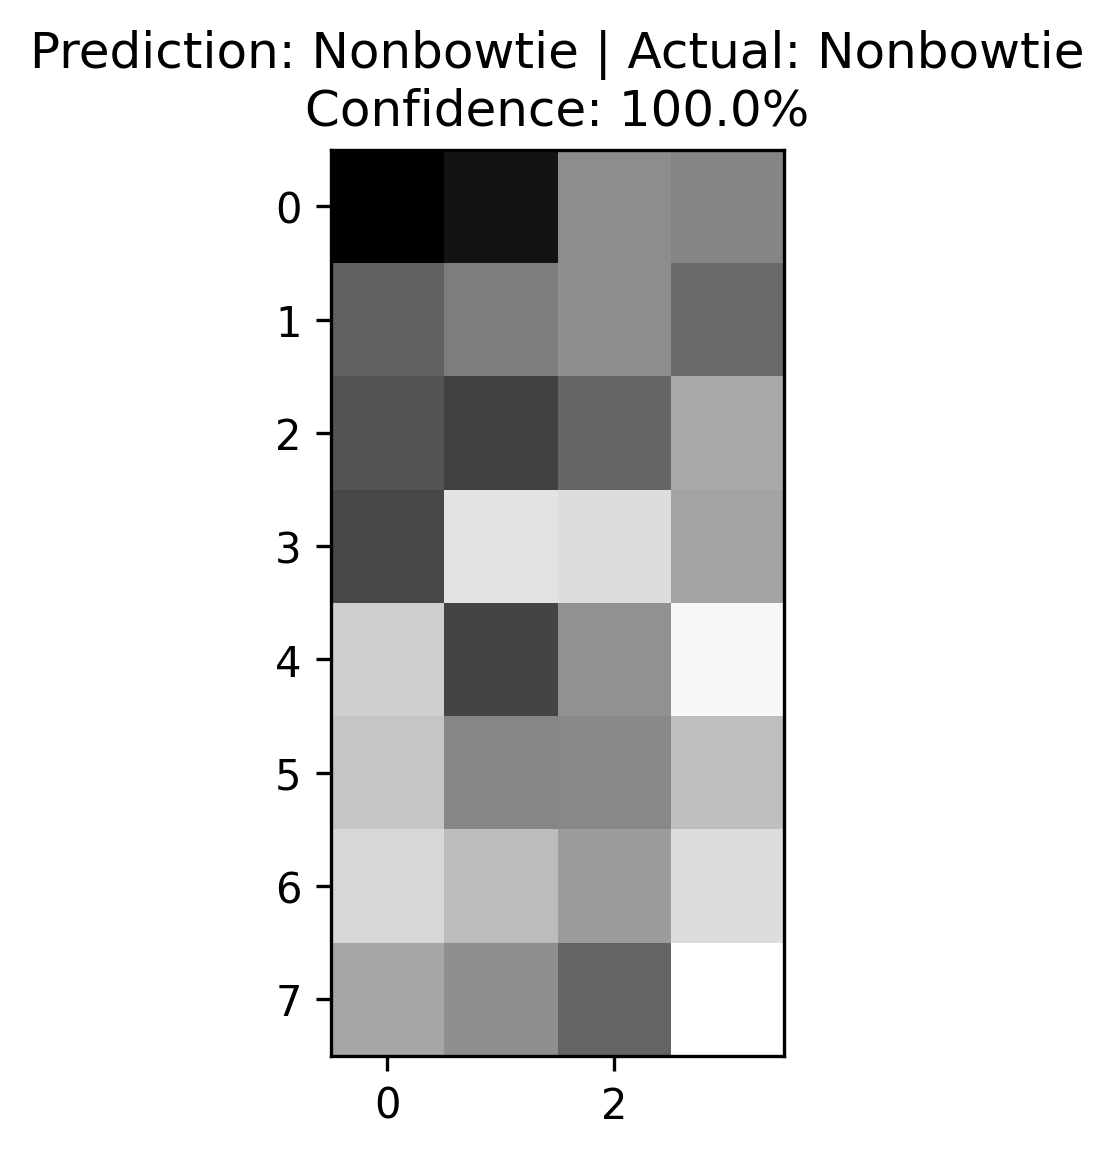

In [34]:
import pickle

from numpy.lib.stride_tricks import as_strided

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

def get_data(file_name):

    data = np.load(file_name)
    features, labels = [], []
    for row in data:
        features.append(row[2:-1])
        labels.append(row[-1])
    return np.array(features), np.array(labels)

def split_data(X_data, y_data, test_size=0.2):
    """
    Splits the data into 2 sets:
        training data: to train the model (80%)
        testing data: to test the final model on unseen data (20%)
    
    returns 2 sets of data (Taining, Testing)
    Each dataset consists of (images, labels)
    """
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size, random_state=42)
    return (X_train, y_train), (X_test, y_test)

def vis(model, X_test, y_test, shape = (16, 8)):
    """
    Display a random image from the test set along with the images actual and predicted labels.
    """
    index=np.random.randint(len(y_test))
    label = y_test[index]
    size = shape[0]*shape[1]
    
    # Some models offer prediction probability try this first
    try:
        prediction = model.predict_proba(np.reshape(X_test[index], (-1, size)))
        pred = np.argmax(prediction)
        confidence = str(round(100*prediction[0][pred], 1))+'%'
    except:
        pred = int(model.predict(np.reshape(X_test[index], (-1, size)))[0])
        confidence = 'N/A'
    
    img = np.reshape(X_test[index], shape)
    plt.close('all')
    plt.gray()
    plt.figure()
    plt.imshow(img)
    plt.title(f'Prediction: {MAP[pred]} | Actual: {MAP[label]}\nConfidence: {confidence}')
    
def evaluate(predictions, actual):
    """Prints the F1 score and accuracy of the predicted values."""
    print('Accuracy', int(100*sum(preds == actual) / len(preds)), '%')  
    print('F1', round(f1_score(actual, predictions), 2))
    print()
    
def max_pool(image, kernel_size = 2, stride = 2, padding = 0):
    '''
    Applies max pool to 2D image.
    image: input 2D array
    kernel_size: int, the size of the window
    stride: int, the stride of the window
    padding: int, implicit zero paddings on both sides of the input
    pool_mode: string, 'max' or 'avg'
    '''
    # reshape image to 2 dimensions (16 by 8)
    image = np.reshape(image, (16, 8))
    
    # Padding
    image = np.pad(image, padding, mode='constant')

    # Window view of A
    output_shape = ((image.shape[0] - kernel_size)//stride + 1,
                    (image.shape[1] - kernel_size)//stride + 1)
    kernel_size = (kernel_size, kernel_size)
    image_w = as_strided(image, shape = output_shape + kernel_size, 
                        strides = (stride*image.strides[0],
                                   stride*image.strides[1]) + image.strides)
    image_w = image_w.reshape(-1, *kernel_size)

    image_w = image_w.max(axis=(1,2)).reshape(output_shape)
    
    # flatten image to 1 dimension
    return np.reshape(image_w, (-1, 1))

if __name__ == "__main__":
    MAP = {1: "Bowtie", 0: "Nonbowtie"}
    
    # Get features (X) and labels (y)
    X, y = get_data('/content/bowtie_tutorial/training_data/data.npy')
    
    # =============================================================================
    # Split the data into a training set and a testing set (depending on the model, sometimes a validation set too)
    # A healthy split is 80% : 20% or 64% : 16% : 20% (train : validation : testing) but we will skew our
    # split towards the training set because we don't have that many samples (1500)
    # =============================================================================
    (X_train, y_train), (X_test, y_test) = split_data(X, y, test_size = 0.10) # 90% Training 10% testing
    
    # =============================================================================
    # Plot the data to make sure that there are an even number of bowties and nonbowties in each 
    # dataset, scikit learn does this for us in the split_data function above but its better to be 
    # safe and check. A model trained on only nonbowties wouldn't be a very good model.
    # =============================================================================
    show_data_dist = True
    if show_data_dist:
        plt.close('all')
        plt.figure() # adjust or delete dpi (dots per inch) if figure size is not right
        bar_width = 0.3
        plt.hist(y_train-bar_width, label = 'train', rwidth=bar_width)
        plt.hist(y_test, label = 'test', rwidth=bar_width)
        plt.xlabel('Left: Non-bowties ; Right: Bowties')
        plt.ylabel('Count')
        plt.xticks([])
        plt.legend()
        
    # =============================================================================
    # Train our first model
    # Notes: sgd relies on randomness during training, selecting a random_state
    #       will ensure it behaves in the same random way each time.
    #       It is a good habit to do so, since it helps with debugging and tuning hyperparameters 
    #
    #       For SGDClassifier loss function options are "hinge", "log", "modified huber" with 
    #       the latter 2 we can get the confidence level for each prediction the 
    #       
    #       We can change between models very easily, however different models will
    #       require different preprocessing steps and have different hyperparameters
    #       to tune.  We won't get into this today but you can try replacing the
    #       model with:
    #                   RidgeClassifier(random_state=42)
    #                   PassiveAggressiveClassifier(random_state=42)
    #                   DecisionTreeClassifier(random_state=42)
    # =============================================================================
    model = SGDClassifier(random_state=42, loss = "modified_huber")
    model.fit(X_train, y_train)
    
    # =============================================================================
    # Save model for future use    
    # Note: model can be reloaded later using pickle.load(open(model_name, 'rb'))
    #       note new data must be processed exactly the same as the data used to
    #       train the model for the model to work well
    # =============================================================================
    model_name = '/content/bowtie_tutorial/trained_classifiers/sgd_classifier.pkl'
    pickle.dump(model, open(model_name, 'wb'))

    # =============================================================================
    # Make some predictions    
    # Notes: Accuracy here is measured as the number of correct predictions over
    #        the number of total predictions made.  However, accuracy is not always
    #        the best metric to judge your model.  A more telling metric is the F1
    #        score which is based on the precision and recall of the model. It is
    #        similar to accuracy in that 1.0 is a perfect model.
    #        Read more about F1 score here: https://en.wikipedia.org/wiki/F-score
    # =============================================================================
    preds = model.predict(X_test)
    actual = y_test
    print("SGD Classifier")
    evaluate(preds, actual) # Acc. 67%, F1 0.74
    
    # =============================================================================
    # Run vis to plot a new prediction each time
    # =============================================================================
    vis(model, X_test, y_test)
    
    # =============================================================================
    # Most models tend to perform better when features similarly scaled. (Decision trees are an exception.)
    # =============================================================================
    
    # Scale features
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit and test the model
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print("SGD Classifier with Standard Scaling")
    evaluate(preds, actual) # Acc. 76%, F1 0.77
    
    # =============================================================================
    # Finally many models suffer from "the curse of dimensionality" meaning too many
    # data points per sample actually hurts the models performance, it's better to choose the
    # features that are most important.
    #
    # One popular method is called max-pooling, only taking the most intense pixel
    # from each pool of say 4 pixels. 
    # =============================================================================
    
    # Apply max pooling to the training and test samples
    X_train = np.array([max_pool(sample) for sample in X_train])
    X_train = np.reshape(X_train, X_train.shape[:2])
    X_test = np.array([max_pool(sample) for sample in X_test])
    X_test = np.reshape(X_test, X_test.shape[:2])
    
    # Fit and test the model
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print("SGD Classifier with Standard Scaling and Max Pooling")
    evaluate(preds, actual) # Acc. 79%, F1 0.8
    
    vis(model, X_test, y_test, shape = (8, 4))

**Part 3: Implement the Classifier**

The final step is to use the trained classifier on new images.  
This script is nearly identical to what was done in Part 1, in which we annotated some images.  
The difference is that before we place a box around a potential bowtie, we extract the 128
features from the region of interest in the shear 0 and shear 45 images, then feed those
features to the machine learning model we trained to predict if it is a bowtie or not.
If it is a bowtie, we box it in white, if it is not a bowtie, then we box it in black.
An important item to note here is that the training images do not overlap with the images
used to create the provided training data.
We created a test set and a training set in the last module to test the model on bowties it had not
seen before.  Similarly, if we used images that were in the training set, the model would appear to
be performing unrealistically well.

<ipython-input-35-8c01c02f6e3d>:91: MatplotlibDeprecationWarning: 
The 'minimumdescent' parameter of __init__() was deprecated in Matplotlib 3.4 and will be removed two minor releases later. If any parameter follows 'minimumdescent', they should be passed as keyword, not positionally.
  offsetbox = TextArea(str(j), minimumdescent=False)


<Figure size 1800x1200 with 0 Axes>

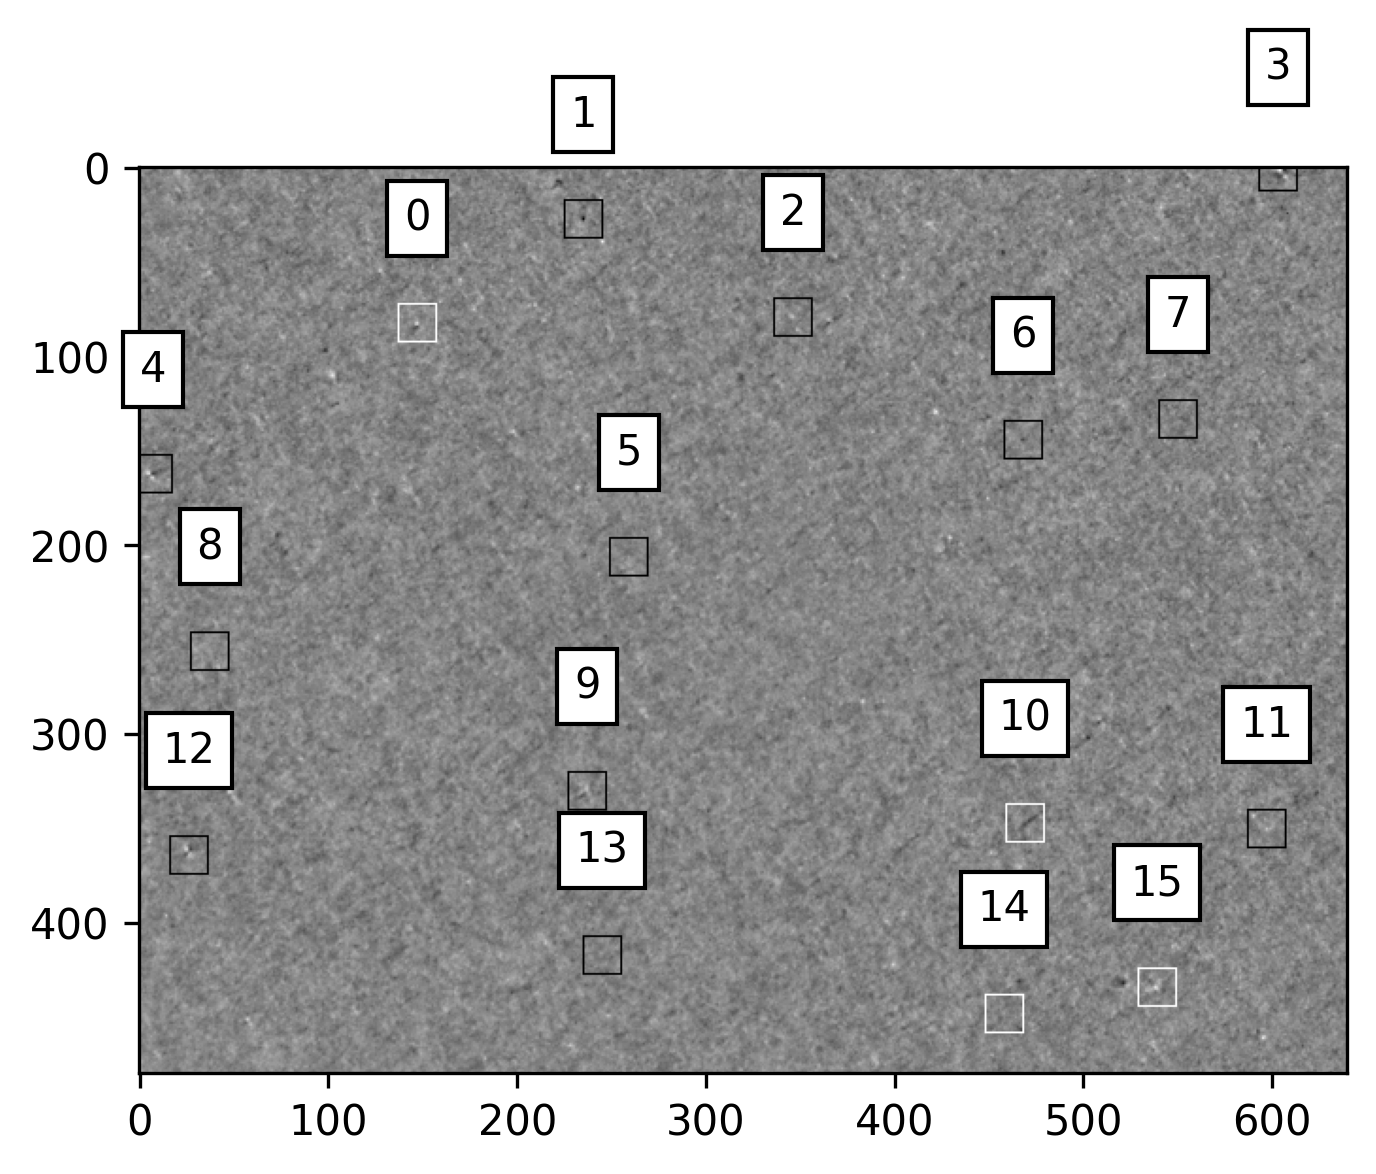

In [35]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

def extract_features(img0, img45, j, i, xdim=640, ydim=480):
    """
    Gets 128 pixel values from the 8 by 8 box centered at i, j in the shear0 and shear45 images.
    If the pixel is too close to the edge of the image returns a zerofilled array.
    Returns a 1D array with 128 pixel values, flattened img0, then flattened img45
    """
    if (i < 4) or (j < 4) or (i > 476) or (j > 636):
        return np.zeros((1, 128))
    data0 = list(np.reshape(img0[i-4: i+4, j-4: j+4], (64,)))
    data45 = list(np.reshape(img45[i-4: i+4, j-4: j+4], (64,)))
    return np.array(data0 + data45).reshape((1, -1))

def add_boxes_clf(image, points, bowties, size=10, xdim=640, ydim=480):
    """
    Places a white box of edge length 2*size around each point in points.
    Returns the image with boxes added.
    
    image: numpy array of dimensions (xdim, ydim)
    points: a list of points to be boxed
    """
    maxi = np.max(image)
    mini = np.min(image)
    for point, bowtie in zip(points, bowties):
        val = maxi if bowtie else mini # white box for bowties or black box for nonbowties    
        j, i = pixel_to_xy(point)
        for di in range(max(0, i-size), min(ydim, i+size+1)):
            if j + size < xdim:
                image[di][j+size] = val
            if j - size >= 0:
                image[di][j-size] = val
        for dj in range(max(0, j-size), min(xdim, j+size+1)):
            if i + size < ydim:
                image[i+size][dj] = val
            if i - size >= 0:
                image[i-size][dj] = val
    return image
        
def annotate_image_clf(file_name, sub0, sub45, img_number, model, N=5, save_dir='/content/bowtie_tutorial/images/classified_images/', hot_pixels=[15968, 15546], xdim=640, ydim=480):
    """
    Annotate the image by placing a box around potential bowties.
    Applies image processing steps: subtraction image and hot pixel removal
    Divides the image into N*N subimages.
    For each subimage, places a box around the most intense pixel.
    The intensity of pixel (i, j) is img0[i][j]**2 + img45[i][j]**2.
    Saves the annotated image.
    
    file_name: path to .dt1 image file
    sub0, sub45: subtraction images (numpy array)
    img_number: number of the image to be saved
    save_dir: location where the annotated images should be saved
    hot_pixels: the pixel id of known hypersensitive pixels
    xdim, ydim: dimensions of the image in pixels (typically 640 by 480)
    """
    # Load the IR transmission, shear0, and shear 45 images
    imgL, img0, img45 = get_images(file_name)
    
    # Replace the hot pixels
    img0 = replace_hot_pixels(img0, hot_pixels)
    img45 = replace_hot_pixels(img45, hot_pixels)
    
    # Apply the subtraction image
    img0 -= sub0
    img45 -= sub45
    
    # Split the shear max image into smaller images
    imgM = img0**2 + img45**2
    small_images = subdivide(imgM, N)
    
    # Record the maximum pixel in each small image
    peak_pixels = [np.argmax(img) for img in small_images]
    peak_pixels = [local_to_global_index(i, j, xdim//N, ydim//N, N) for j,i in enumerate(peak_pixels)]
    
    # Classify each location as a bowtie or non bowtie
    features = [extract_features(img0, img45, *pixel_to_xy(i)) for i in peak_pixels]
    bowties = [model.predict(data) for data in features]
    
    # Place a white box around each peak pixel
    img0 = add_boxes_clf(img0, peak_pixels, bowties)
    img45 = add_boxes_clf(img45, peak_pixels, bowties)
    
    # Annotate each box with a number
    for image, name in [(img0, str(img_number) + '_0'), (img45, str(img_number) + '_45')]:
        plt.close('all')
        plt.gray()
        fig,ax=plt.subplots()
        ax.imshow(image)
        for j,i in enumerate(peak_pixels):        
            offsetbox = TextArea(str(j), minimumdescent=False)
            box = AnnotationBbox(offsetbox, (i%xdim, i//xdim), xybox=(0, 25), 
                                 xycoords='data', boxcoords="offset points")
            ax.add_artist(box)
        
        # Save the annotated image
        plt.savefig(f"{save_dir}{name}.png")

if __name__ == "__main__":
    
    # Get subtraction images, hot pixels, and file names
    sub0 = np.load('/content/bowtie_tutorial/images/subtraction_images/sub0.npy')
    sub45 = np.load('/content/bowtie_tutorial/images/subtraction_images/sub45.npy')
    hot_pixels = [15968, 15546]
    FILES = glob.glob('/content/bowtie_tutorial/Wafer_Data_Files/*.dt1')
    
    # Choose how many subregions to split the image into 
    N = 4 # there will be N * N subregions
    
    # load the previously trained classifier
    model = pickle.load(open('/content/bowtie_tutorial/trained_classifiers/sgd_classifier.pkl', 'rb'))
    
    # Set run all images to true to classify all 25 images
    run_all_images = False
    if not run_all_images:
        # Pick an image from 0 to 24
        IMAGE_NUMBER = 0
        annotate_image_clf(FILES[IMAGE_NUMBER], sub0, sub45, IMAGE_NUMBER, model, N=N)
    else:
        for img_number, file_name in enumerate(FILES):
            print('Annotating',img_number, '/', len(FILES))
            annotate_image_clf(file_name, sub0, sub45, img_number, model, N=N)

**Assignment:**

Find an image in which a bowtie is visible to the "naked eye", and correctly identified using the SGD classifier at one number of subregions (N), but not at a smaller number of subregions.  Briefly explain why this is happening.

*(Hint: this can all be done within the last code block, by changing two numbers and inspecting the image above.  Note that the resolution has been increased to 300 dpi to help you see the bowties.)*

Turn in the annotated images for the N value that works, and for the N value that doesn't work.